In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from tcvae import predict, dataset, localconfig
from tcvae.compute_measures import heuristic_names
from matplotlib import pyplot as plt
from IPython.display import Audio
plt.style.use("dark_background")

In [2]:
conf = localconfig.LocalConfig()
conf.load_config_from_file(
    "checkpoints/cnn_ae64_l1_db_no_mag_scale/Default_cnn_ae64_heuristic_l1_db_no_mag_scale_fn.json"
)
conf.dataset_dir = "complete_dataset"
conf.batch_size = 1
conf.mag_scale_fn = None

_, _, test = dataset.get_dataset(conf)
test_iter = iter(test)

In [3]:
_model = predict.load_model(
    conf,
    "checkpoints/cnn_ae64_l1_db_no_mag_scale/84_cnn_ae64_heuristic_l1_db_no_mag_scale_fn_0.01245.h5"
)

Creating VAE


In [ ]:
batch = next(test_iter)

In [ ]:
heuristic_names

In [ ]:
(f0_shifts_true, f0_shifts_pred, mag_env_true, mag_env_pred,
     h_freq_shifts_true, h_freq_shifts_pred, h_mag_dist_true,
     h_mag_dist_pred, mask), note_number_orig = predict.get_intermediate_values(
    _model, batch, conf)

In [ ]:
plt.plot(f0_shifts_true[0]);

In [ ]:
plt.plot(f0_shifts_pred[0]);

In [ ]:
plt.plot(mag_env_true[0]);

In [ ]:
plt.plot(mag_env_pred[0]);

In [ ]:
plt.plot(h_freq_shifts_true[0]);

In [ ]:
plt.plot(h_freq_shifts_pred[0]);

In [ ]:
plt.plot(h_mag_dist_true[0]);

In [ ]:
plt.plot(h_mag_dist_pred[0]);

In [ ]:
h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
    predict.get_freq_and_mag_batch(_model, batch, conf)

In [ ]:
plt.plot(h_mag_true[0]);

In [ ]:
plt.plot(h_mag_pred[0]);

In [ ]:
audio_true = predict.reconstruct_audio(h_freq_true, h_mag_true, conf)
audio_pred = predict.reconstruct_audio(h_freq_pred, h_mag_pred, conf)

In [ ]:
Audio(audio_true, rate=16000)

In [ ]:
Audio(audio_pred, rate=16000)

## Changing Heurisitic Measures

In [218]:
print(heuristic_names)

batch = next(test_iter)

['inharmonicity', 'even_odd', 'sparse_rich', 'attack_rms', 'decay_rms', 'attack_time', 'decay_time', 'bass', 'mid', 'high_mid', 'high']


In [231]:
h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
    predict.get_freq_and_mag_batch(
        _model, batch, conf,
        # high_mid=0, high=0,
        # bass=2
        # inharmonicity=-2.
        # even_odd=-2.
        # sparse_rich=2,
        # decay_time=0,
        # attack_time=0.
    )

audio_true = predict.reconstruct_audio(h_freq_true, h_mag_true, conf)
audio_pred = predict.reconstruct_audio(h_freq_pred, h_mag_pred, conf)

Changing value for decay_time from 0.4697265625 to 0.0


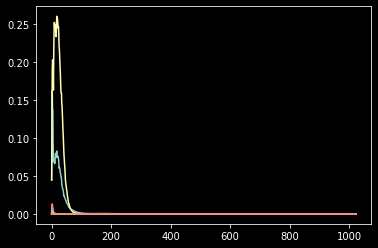

In [232]:
plt.plot(h_mag_pred[0]);

In [233]:
Audio(audio_true, rate=16000)

In [234]:
Audio(audio_pred, rate=16000)

## Export Some Examples


In [4]:
import soundfile as sf


def write_audio(h_freq, h_mag, conf, audio_path):
    audio = predict.reconstruct_audio(h_freq, h_mag, conf)
    audio = np.squeeze(audio.numpy())
    audio = audio / np.max(np.abs(audio))
    sf.write(audio_path, audio, samplerate=conf.sample_rate)


for i in range(0, 20):
    batch = next(test_iter)
    h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
        predict.get_freq_and_mag_batch(_model, batch, conf)

    true_path = os.path.join(os.getcwd(), "predictions", f"{i}_true.wav")
    pred_path = os.path.join(os.getcwd(), "predictions", f"{i}_pred.wav")

    write_audio(h_freq_true, h_mag_true, conf, true_path)
    write_audio(h_freq_pred, h_mag_pred, conf, pred_path)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
